In [1]:
"""
Notebook for Exploring, Cleaning, and Preprocessing the Diabetes Dataset.
"""

'\nNotebook for Exploring, Cleaning, and Preprocessing the Diabetes Dataset.\n'

# 1. Data Exploration and Preprocessing

**Goal:** Load the raw diabetes dataset, explore its characteristics, clean it, perform feature engineering/selection, preprocess it for modeling, and save the final train, validation, and test sets.

**Skills Demonstrated:**
- Python, Pandas, Numpy for data manipulation
- Matplotlib, Seaborn for Exploratory Data Analysis (EDA)
- Scikit-learn for preprocessing (Splitting, Scaling, Encoding)
- Handling missing values
- Feature engineering (basic)
- Understanding data distributions and relationships
- Structured approach using functions from `src` modules

In [2]:
# Import necessary libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import os
import sys

# Add src directory to Python path to import custom modules
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import data_loader, preprocess

# Configure plotting style
sns.set(style="whitegrid")
%matplotlib inline

## 1.1 Load Configuration and Raw Data

Load the project configuration and the raw dataset using our `data_loader` module. We'll also optionally demonstrate loading from the SQLite DB if `db_utils.py` was run.

In [3]:
# Load config
config_path = '../config/model_config.yaml' # Path relative to notebook location
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

paths = config['paths']
cfg_prep = config['preprocessing']

In [4]:
# Load raw data from CSV
try:
    df_raw = data_loader.load_raw_data(f"../{paths['raw_data']}") # Adjust path relative to notebook
    print("Raw data loaded from CSV:")
    print(df_raw.head())
    print(df_raw.info())
except FileNotFoundError as e:
    print(e)
    print("Please ensure 'diabetic_data.csv' is in the 'data/raw/' directory.")
    # Stop execution if file not found
    # raise

2025-03-31 18:24:11,260 - INFO - Loading raw data from: ../data/raw/diabetic_data.csv
2025-03-31 18:24:11,759 - INFO - Raw data loaded successfully. Shape: (101766, 50)


Raw data loaded from CSV:
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No   

In [ ]:
# (Optional) Load raw data from SQLite DB - Uncomment if you ran db_utils.py
# db_path_relative = f"../{paths['db_path']}"
# if os.path.exists(db_path_relative):
#     print("\nLoading raw data from SQLite DB...")
#     df_raw_db = data_loader.load_data_from_db(db_path_relative)
#     if df_raw_db is not None:
#         print(df_raw_db.head())
#     else:
#         print("Could not load data from DB.")
# else:
#     print("\nSQLite DB not found. Run src/db_utils.py to create it.")

## 1.2 Initial Data Exploration (EDA)
Perform basic EDA on the raw data.
- Check dimensions
- Look at data types
- Examine missing values (represented as '?')
- Analyze the target variable distribution

In [5]:
print(f"Dataset dimensions: {df_raw.shape}")

Dataset dimensions: (101766, 50)


In [6]:
# Check for '?' representing missing values
print("\nColumns with '?' values:")
missing_q = (df_raw == '?').sum()
print(missing_q[missing_q > 0])


Columns with '?' values:
race                  2273
weight               98569
payer_code           40256
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
dtype: int64



Target variable distribution ('readmitted'):
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

Normalized distribution:
readmitted
NO     0.539119
>30    0.349282
<30    0.111599
Name: proportion, dtype: float64


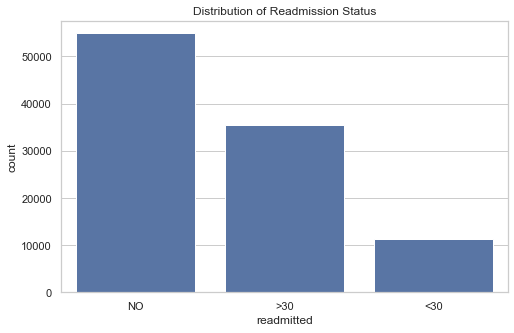

In [7]:
# Analyze target variable 'readmitted'
print("\nTarget variable distribution ('readmitted'):")
print(df_raw['readmitted'].value_counts())
print("\nNormalized distribution:")
print(df_raw['readmitted'].value_counts(normalize=True))

plt.figure(figsize=(8, 5))
sns.countplot(data=df_raw, x='readmitted')
plt.title('Distribution of Readmission Status')
plt.show()

**Observations:**
- Several columns (`weight`, `payer_code`, `medical_specialty`) have a high number of missing values ('?'). These are candidates for dropping.
- Other columns also have missing values that need handling.
- The target variable shows imbalance: 'NO' readmission is the most frequent category. We are interested in predicting `<30` days readmission, making this a binary classification problem after mapping.

## 1.3 Data Cleaning and Target Mapping
Apply the cleaning steps defined in `src/preprocess.py`.
- Replace '?' with NaN.
- Drop specified columns.
- Drop rows with missing values in key columns (simplification for demo).
- Handle duplicates (keeping first encounter per patient).
- Map categorical 'age' to numerical.
- Map the target variable `readmitted` to binary (1 for `<30`, 0 otherwise).

In [8]:
# Apply cleaning function
df_cleaned = preprocess.clean_data(df_raw.copy(), cfg_prep['drop_cols']) # Use copy to avoid modifying df_raw

2025-03-31 18:24:37,686 - INFO - Starting data cleaning...
2025-03-31 18:24:37,909 - INFO - Replaced '?' with NaN. Shape: (101766, 50)
2025-03-31 18:24:37,960 - INFO - Dropped specified columns. Shape: (101766, 45)
2025-03-31 18:24:38,039 - INFO - Dropped 3713 rows with missing values in key columns. Shape: (98053, 45)
2025-03-31 18:24:38,045 - INFO - Mapped 'age' column to numerical values.
2025-03-31 18:24:38,046 - INFO - Data cleaning finished.


2025-03-31 18:24:41,555 - INFO - Mapping target variable 'readmitted'...
2025-03-31 18:24:41,637 - INFO - Target variable mapped. Value counts:
readmitted
0    0.887143
1    0.112857
Name: proportion, dtype: float64
2025-03-31 18:24:41,728 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-31 18:24:41,775 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



Target variable distribution after mapping:
readmitted
0    0.887143
1    0.112857
Name: proportion, dtype: float64


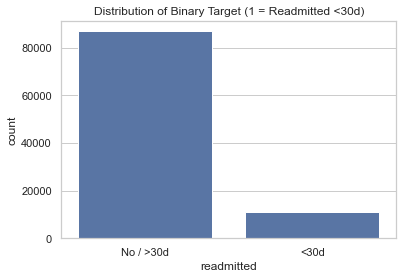

In [9]:
# Apply target mapping function
df_mapped = preprocess.map_target(df_cleaned, cfg_prep['target_col'], cfg_prep['target_map'])

print("\nTarget variable distribution after mapping:")
print(df_mapped[cfg_prep['target_col']].value_counts(normalize=True))

plt.figure(figsize=(6, 4))
sns.countplot(data=df_mapped, x=cfg_prep['target_col'])
plt.title('Distribution of Binary Target (1 = Readmitted <30d)')
plt.xticks([0, 1], ['No / >30d', '<30d'])
plt.show()

**Observation:** The target variable remains imbalanced after mapping to binary, with the positive class (`<30` days readmission) being the minority. This needs to be addressed during modeling (e.g., class weights, appropriate metrics).

## 1.4 Feature Identification and Splitting
Identify numerical and categorical features and split the data into training, validation, and test sets *before* applying scaling and encoding.

In [10]:
# Identify feature types (as done in preprocess_pipeline)
potential_numeric = cfg_prep['numeric_cols']
all_cols = df_mapped.drop(columns=[cfg_prep['target_col']]).columns
numeric_features = [col for col in potential_numeric if col in all_cols]
categorical_features = [col for col in all_cols if col not in numeric_features]

print(f"\nIdentified {len(numeric_features)} numeric features.")
# print(numeric_features)
print(f"Identified {len(categorical_features)} categorical features.")
# print(categorical_features)


Identified 8 numeric features.
Identified 36 categorical features.


In [11]:
# Split data using the function from preprocess.py
train_df_unprocessed, val_df_unprocessed, test_df_unprocessed = preprocess.split_data(
    df_mapped,
    cfg_prep['target_col'],
    cfg_prep['test_size'],
    cfg_prep['validation_size'],
    cfg_prep['random_state']
)

print("\nData split summary:")
print(f"Train set shape (unprocessed): {train_df_unprocessed.shape}")
print(f"Validation set shape (unprocessed): {val_df_unprocessed.shape}")
print(f"Test set shape (unprocessed): {test_df_unprocessed.shape}")

2025-03-31 18:24:53,199 - INFO - Splitting data into train, validation, and test sets...
2025-03-31 18:24:53,356 - INFO - Data split complete:
2025-03-31 18:24:53,358 - INFO - Train set shape: (58831, 44), Target distribution:
readmitted
0    0.887134
1    0.112866
Name: proportion, dtype: float64
2025-03-31 18:24:53,360 - INFO - Validation set shape: (19611, 44), Target distribution:
readmitted
0    0.887155
1    0.112845
Name: proportion, dtype: float64
2025-03-31 18:24:53,362 - INFO - Test set shape: (19611, 44), Target distribution:
readmitted
0    0.887155
1    0.112845
Name: proportion, dtype: float64



Data split summary:
Train set shape (unprocessed): (58831, 45)
Validation set shape (unprocessed): (19611, 45)
Test set shape (unprocessed): (19611, 45)


## 1.5 Preprocessing (Scaling and Encoding) and Saving
- Create the preprocessor (StandardScaler for numeric, OneHotEncoder for categorical).
- **Fit** the preprocessor **only** on the **training data**.
- **Transform** all three sets (train, validation, test) using the **fitted** preprocessor.
- Save the processed datasets.

In [12]:
# Create the preprocessor
preprocessor = preprocess.create_preprocessor(numeric_features, categorical_features)

# Fit on training data
X_train_unprocessed = train_df_unprocessed.drop(columns=[cfg_prep['target_col']])
print("\nFitting preprocessor on training data...")
preprocessor.fit(X_train_unprocessed)
print("Preprocessor fitted.")

2025-03-31 18:25:01,506 - INFO - Creating preprocessor pipeline...
2025-03-31 18:25:01,508 - INFO - Preprocessor created.



Fitting preprocessor on training data...
Preprocessor fitted.


In [13]:
# Define the apply_preprocessing helper function (copied from preprocess.py for notebook use)
def apply_preprocessing_notebook(df_in: pd.DataFrame, target_col: str, prep) -> pd.DataFrame:
    X = df_in.drop(columns=[target_col])
    y = df_in[target_col]
    print(f"Applying preprocessor to data with shape: {X.shape}")
    X_processed = prep.transform(X)
    # Get feature names after transformation
    try:
        # For sklearn >= 1.0
        feature_names = prep.get_feature_names_out()
    except AttributeError:
         # Fallback for older sklearn or different ColumnTransformer structure
         # This part might need adjustment based on the exact sklearn version and preprocessor steps
        feature_names = []
        for name, trans, cols in prep.transformers_:
            if hasattr(trans, 'get_feature_names_out'):
                 # Handle transformers like OneHotEncoder
                f_names = trans.get_feature_names_out(cols)
                feature_names.extend(f_names)
            elif name != 'remainder':
                 # Handle transformers like StandardScaler
                 feature_names.extend(cols)
            elif trans == 'passthrough':
                 # Handle remainder='passthrough'
                 rem_cols = [c for c in X.columns if c not in prep._feature_names_in] # Access internal attr, maybe fragile
                 feature_names.extend(rem_cols)


    X_processed_df = pd.DataFrame(X_processed, columns=feature_names, index=X.index)
    print(f"Processed data shape: {X_processed_df.shape}")
    # Ensure y index matches X_processed_df before concatenation
    y = y.loc[X_processed_df.index] # Align index
    return pd.concat([X_processed_df, y], axis=1)

In [14]:
# Apply preprocessing to all splits
print("\nApplying preprocessing to training set...")
train_processed_df = apply_preprocessing_notebook(train_df_unprocessed, cfg_prep['target_col'], preprocessor)

print("\nApplying preprocessing to validation set...")
val_processed_df = apply_preprocessing_notebook(val_df_unprocessed, cfg_prep['target_col'], preprocessor)

print("\nApplying preprocessing to test set...")
test_processed_df = apply_preprocessing_notebook(test_df_unprocessed, cfg_prep['target_col'], preprocessor)


Applying preprocessing to training set...
Applying preprocessor to data with shape: (58831, 44)
Processed data shape: (58831, 2220)

Applying preprocessing to validation set...
Applying preprocessor to data with shape: (19611, 44)
Processed data shape: (19611, 2220)

Applying preprocessing to test set...
Applying preprocessor to data with shape: (19611, 44)
Processed data shape: (19611, 2220)


In [15]:
# Display head of processed training data
print("\nHead of processed training data:")
print(train_processed_df.head())
print(f"\nNumber of features after preprocessing: {train_processed_df.shape[1] - 1}") # -1 for target col


Head of processed training data:
       num__time_in_hospital  num__num_lab_procedures  num__num_procedures  \
21175              -1.145663                -2.132842            -0.204312   
11323              -0.812482                -1.575279            -0.204312   
45414               0.853422                -0.662901            -0.788310   
25856              -0.479301                -0.054650            -0.788310   
6061                2.852508                -0.206713            -0.204312   

       num__num_medications  num__number_outpatient  num__number_emergency  \
21175             -0.140697               -0.293598              -0.212104   
11323              0.226825               -0.293598              -0.212104   
45414              0.471839               -0.293598              -0.212104   
25856             -0.630725               -0.293598              -0.212104   
6061              -0.630725               -0.293598              -0.212104   

       num__number_inpatient

**Observation:** One-Hot Encoding significantly increased the number of features, especially due to diagnosis codes and medications. This high dimensionality might pose challenges for some models but is handled by Neural Networks. Feature selection or embedding layers could be considered for optimization.

In [16]:
# Save processed data
processed_dir = f"../{paths['processed_data_dir']}"
os.makedirs(processed_dir, exist_ok=True)

train_save_path = f"../{paths['train_data']}"
val_save_path = f"../{paths['val_data']}"
test_save_path = f"../{paths['test_data']}"

data_loader.save_processed_data(train_processed_df, train_save_path)
data_loader.save_processed_data(val_processed_df, val_save_path)
data_loader.save_processed_data(test_processed_df, test_save_path)

print(f"\nProcessed data saved to {processed_dir}")

2025-03-31 18:26:33,933 - INFO - Data saved successfully to: ../data/processed/train.csv
2025-03-31 18:26:53,973 - INFO - Data saved successfully to: ../data/processed/val.csv
2025-03-31 18:27:14,111 - INFO - Data saved successfully to: ../data/processed/test.csv



Processed data saved to ../data/processed/


## 1.6 Conclusion

The data has been successfully explored, cleaned, preprocessed, and split into training, validation, and test sets. The resulting CSV files in `data/processed/` are ready to be used for model training and evaluation. The preprocessing steps (scaling, encoding) were fitted only on the training data to prevent data leakage.